<a href="https://colab.research.google.com/github/nwon24/basel/blob/main/Basel_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset,DataLoader,TensorDataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from datetime import date

In [11]:
#file="/content/drive/MyDrive/Colab Notebooks/Basel_2024-25.csv"
file="/content/drive/MyDrive/Colab Notebooks/Basel_2001-25.csv"

df=pd.read_csv(file,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
nparr=df.to_numpy(dtype=np.float64)


In [36]:
predwin=336
testhours=1000
totalhours=nparr.size
train_split=nparr[:-testhours]
test_split=nparr[-testhours:]


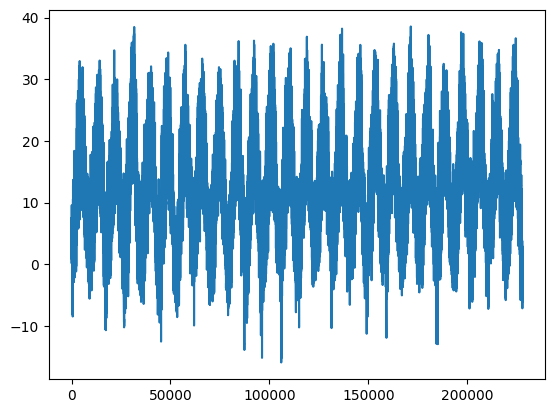

In [13]:
plt.plot(np.arange(totalhours),nparr)
plt.show()

In [37]:
#scaler=MinMaxScaler(feature_range=(0,1))
scaler=MinMaxScaler(feature_range=(-1,1))
train_data=(torch.from_numpy(scaler.fit_transform(train_split)))
test_data=(torch.from_numpy(scaler.transform(test_split)))

In [38]:
def preparexy(data,predwin):
    n=len(data)-predwin
    x=torch.zeros((n,predwin,1))
    y=torch.zeros(n)
    for i in range(n):
        x[i]=data[i:i+predwin]
        y[i]=data[i+predwin]
    return x,y

xtrain,ytrain=preparexy(train_data,predwin)
xtest,ytest=preparexy(test_data,predwin)

In [39]:
class lstm(nn.Module):
    def __init__(self,inputsize,hiddensize,nlayers,outputsize,batch_first=True,dropout=0.0):
        super().__init__()
        self.inputsize=inputsize
        self.hiddensize=hiddensize
        self.nlayers=nlayers
        self.batch_first=batch_first
        self.outputsize=outputsize
        self.dropout=dropout
        self.lstm=nn.LSTM(self.inputsize,self.hiddensize,self.nlayers,batch_first=self.batch_first,dropout=dropout)
        self.linear=nn.Linear(self.hiddensize,outputsize)

    def forward(self,x):
        out,_=self.lstm(x)
        return self.linear(out[:,-1,:])

In [40]:
inputsize=1
nlayers=2
hiddensize=128
outputsize=1

dropout=0.4
lr=1e-3

model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)
lossfn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


In [41]:
batch_size=64
epochs=50

traindataset=TensorDataset(xtrain,ytrain)
trainloader=DataLoader(traindataset,batch_size=batch_size,shuffle=True)
testdataset=TensorDataset(xtest,ytest)
testloader=DataLoader(testdataset,batch_size=batch_size,shuffle=True)

In [42]:
for epoch in range(epochs):
    model.train()
    trainloss=0.0
    testloss=0.0
    for x,y in trainloader:
        pred=model(x)
        loss=lossfn(pred,y.reshape(pred.shape))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    model.eval()
    with torch.no_grad():
        for x,y in testloader:
            pred=model(x)
            loss=lossfn(pred,y.reshape(pred.shape))
            testloss+=loss.item()

    print(f"Epoch {epoch}: avg train loss = {trainloss/len(trainloader):.5f}, avg test loss = {testloss/len(testloader):.5f}")
    if (epoch+1)%5==0 and epoch>0:
        torch.save(model.state_dict(),f"/content/drive/MyDrive/Colab Notebooks/Basel_LSTM_{date.today()}_{10}e_{dropout}d_{predwin}.pth")


Epoch 0: avg train loss = 0.00169, avg test loss = 0.00047


KeyboardInterrupt: 

In [20]:
savepath=f"/content/drive/MyDrive/Colab Notebooks/Basel_LSTM_{date.today()}_{10}e_{dropout}d.pth"

In [21]:
torch.save(model.state_dict(),savepath)

In [ ]:
model.load_state_dict(torch.load(savepath,weights_only=True))

<All keys matched successfully>

In [ ]:
horizon=6
hist=xtest[-1].clone().detach()
forecasts=np.zeros(horizon)

for i in range(horizon):
    forecast=model(hist.reshape(1,-1,1))
    forecasts[i]=forecast.item()
    hist=hist.roll(shifts=-1)
    hist[-1]=forecast


In [ ]:
forecastx=np.arange(totalhours,totalhours+horizon)
plt.plot(forecastx,scaler.inverse_transform(forecasts.reshape(-1,1)))
plt.plot(np.arange(totalhours-testhours,totalhours),test_split)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    preds=torch.zeros(testhours-predwin)
    for i,x in enumerate(xtest):
        pred=model(x.reshape(1,-1,1))
        preds[i]=pred.item()

r2_scaled=r2_score(ytest.detach().numpy(),preds.detach().numpy())
#r2_unscaled=r2_score(scaler.inverse_transform(ytest.detach().numpy().reshape(-1,1)),
#                     scaler.inverse_transform(preds.detach().numpy().reshape(-1,1)))
print(f"r2 scaled score: {r2_scaled:.4f}")
#print(f"r2 unscaled score: {r2_unscaled:.4f}")

In [ ]:
horizon=len(xtest)
hist=xtest[0].clone().detach()
forecasts=np.zeros(horizon)

for i in range(horizon):
    forecast=model(hist.reshape(1,-1,1))
    forecasts[i]=forecast.item()
    #hist=hist.roll(shifts=-1)
    #hist[-1]=forecast
    hist=xtest[i].clone().detach()



In [ ]:
x=np.arange(totalhours-horizon,totalhours)
plt.plot(x,scaler.inverse_transform(forecasts.reshape(-1,1)))
plt.plot(x,test_split[predwin:])

plt.show()

NameError: name 'horizon' is not defined

In [ ]:
from sklearn.metrics import r2_score

horizon=100
hist=xtest[0].clone().detach()
forecasts=np.zeros(horizon)

for i in range(horizon):
    forecast=model(hist.reshape(1,-1,1))
    forecasts[i]=forecast.item()
    hist=hist.roll(shifts=-1)
    hist[-1]=forecast

print(f"r2 forecast score: {r2_score(test_split[predwin:predwin+horizon], scaler.inverse_transform(forecasts.reshape(-1,1)))}")

r2 forecast score: 0.45366685181088695


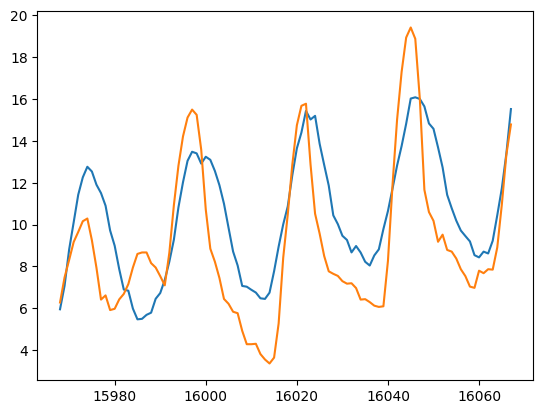

In [ ]:
x=np.arange(totalhours-testhours,totalhours-testhours+horizon)
plt.plot(x,scaler.inverse_transform(forecasts.reshape(-1,1)),label="predicted")
plt.plot(x,test_split[predwin:predwin+horizon],label="actual")

plt.show()

In [32]:
def visualsubs(model,xtest,shape,predwin,horizon):
    hist=xtest[0].clone().detach()
    forecasts=np.zeros(horizon)

    for i in range(horizon):
        hist=xtest[i].clone().detach()
        forecast=model(hist.reshape(shape))
        forecasts[i]=forecast.item()
        print(f"Forecast: {forecasts[i]}")
        print(f"Actual: {ytest[i]}")
        #hist=hist.roll(shifts=-1)
        #hist[-1]=forecast

    x=np.arange(totalhours-testhours,totalhours-testhours+horizon)
    transformed=scaler.inverse_transform(forecasts.reshape(-1,1))
    plt.figure()
    plt.plot(x,transformed,label="predicted")
    plt.plot(x,test_split[predwin:predwin+horizon],label="actual")

    plt.legend(loc="best")
    plt.show()

    return r2_score(test_split[predwin:predwin+horizon],transformed),(1/len(x))*np.sum((transformed-test_split[predwin:predwin+horizon])-transformed**2)


In [24]:
def visualisetest(model,xtest,shape,predwin):
    horizon=len(xtest)
    hist=xtest[0].clone().detach()
    forecasts=np.zeros(horizon)

    for i in range(horizon):
        hist=xtest[i].clone().detach()
        forecast=model(hist.reshape(shape))
        forecasts[i]=forecast.item()
        #hist=hist.roll(shifts=-1)
        #hist[-1]=forecast

    x=np.arange(totalhours-horizon,totalhours)
    plt.figure()
    plt.plot(x,scaler.inverse_transform(forecasts.reshape(-1,1)),label="predicted")
    plt.plot(x,test_split[predwin:],label="actual")
    plt.legend(loc="best")

    plt.show()

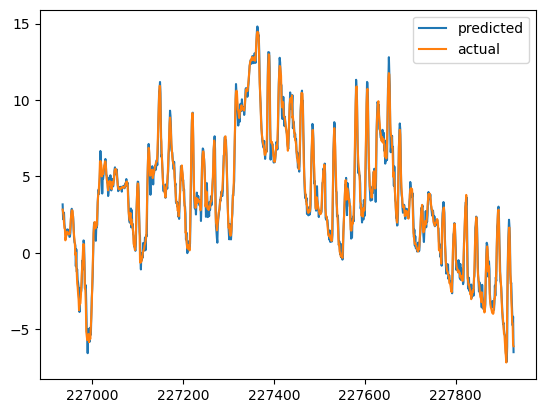

In [25]:
visualisetest(model,xtest,(1,-1,1),predwin)

In [26]:
visualsubs(model,xtest,(1,-1,1),predwin)

TypeError: visualsubs() missing 1 required positional argument: 'horizon'

In [28]:
print(model(xtest[0].reshape(1,-1,1)))
print(ytest[0])


tensor([[0.3746]], grad_fn=<AddmmBackward0>)
tensor(0.3833)


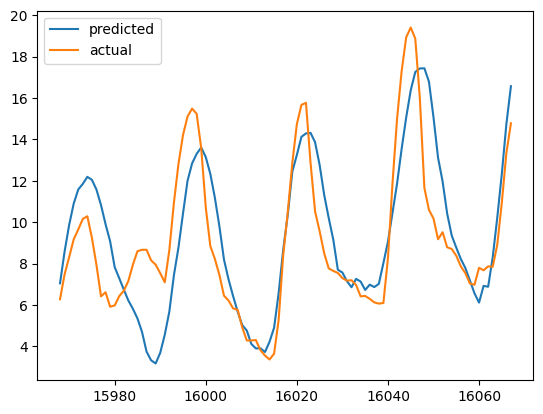

0.5617668256013222

In [ ]:
visualsubs(model,xtest,(1,-1,1),predwin)

Forecast: -0.28076696395874023
Actual: -0.31083810329437256
Forecast: -0.33294668793678284
Actual: -0.31707319617271423
Forecast: -0.3069222867488861
Actual: -0.3244085907936096
Forecast: -0.323108047246933
Actual: -0.34311389923095703
Forecast: -0.3707159161567688
Actual: -0.3552173376083374
Forecast: -0.3709086775779724
Actual: -0.35815149545669556
Forecast: -0.36587366461753845
Actual: -0.3845589756965637
Forecast: -0.39982742071151733
Actual: -0.37832388281822205
Forecast: -0.38140159845352173
Actual: -0.3706216812133789
Forecast: -0.36664074659347534
Actual: -0.3662204444408417
Forecast: -0.35629114508628845
Actual: -0.3636530637741089
Forecast: -0.3507098853588104
Actual: -0.36548689007759094
Forecast: -0.36398449540138245
Actual: -0.3695213794708252
Forecast: -0.3717740774154663
Actual: -0.36988815665245056
Forecast: -0.37740153074264526
Actual: -0.36768752336502075
Forecast: -0.3733750879764557
Actual: -0.3702549338340759
Forecast: -0.3684561848640442
Actual: -0.363653063774108

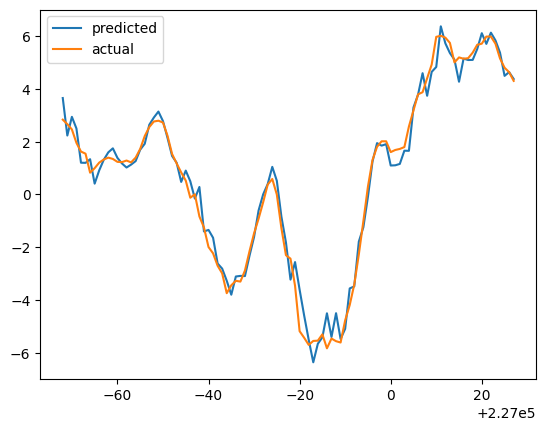

(0.9808590992553631, np.float64(-11.38689666911859))

In [34]:
visualsubs(model,xtest,(1,-1,1),predwin,100)

In [32]:
!pip install pennylane
import pennylane as qml
#!pip install pennylane-lightning-gpu
#!pip install custatevec_cu12
#!pip install custatevec-cu11
#!pip install quimb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 41.5 MB/s eta 0:00:00


In [ ]:
!python -m pip install pennylane pennylane-lightning pennylane-lightning-gpu --upgrade
!pip install custatevec-cu12

In [ ]:
!python -m pip install nvidia-cusparse-cu11 nvidia-cublas-cu11 nvidia-cuda-runtime-cu11 custatevec-cu11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 997.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 17.4 MB/s eta 0:00:00


In [54]:
qpredwin=336
nqubits=9
#qdev="lightning.gpu"
#qdev="default.qubit"
qdev="lightning.qubit"
dev=qml.device(qdev,wires=nqubits)
#dev=qml.device("default.qubit",wires=nqubits)
nlayers=4

@qml.qnode(dev)
def qnode(inputs,weights):
    #print(inputs.shape)
    for i in range(nqubits):
        qml.Hadamard(wires=i)
    #for i in range(len(inputs)):
    #    qml.RY(inputs[i],wires=i%nqubits)
    qml.AmplitudeEmbedding(inputs,wires=range(nqubits),pad_with=0,normalize=True)

    for i in range(nlayers):
        for j in range(nqubits-1):
            qml.CNOT(wires=[j,j+1])
        qml.CNOT(wires=[0,nqubits-1])
        for j in range(nqubits):
            qml.Rot(*weights[i][j],wires=j)
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]

In [55]:
weightshapes={"weights": (nlayers,nqubits,3)}
qlayer=qml.qnn.TorchLayer(qnode,weightshapes)

In [56]:
class qmodel(nn.Module):
    def __init__(self,outputsize):
        super().__init__()
        self.qlayer=qlayer
        self.outputsize=outputsize
        self.lin=nn.Linear(nqubits,outputsize)

    def forward(self,x):
        y=self.qlayer(x)
        #print(y.shape)
        return self.lin(y)



In [57]:
qnn=qmodel(outputsize)

In [58]:
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-01-28_44e_4l.pth",weights_only=True))

RuntimeError: Error(s) in loading state_dict for qmodel:
	size mismatch for qlayer.weights: copying a param with shape torch.Size([4, 8, 3]) from checkpoint, the shape in current model is torch.Size([4, 9, 3]).
	size mismatch for lin.weight: copying a param with shape torch.Size([1, 8]) from checkpoint, the shape in current model is torch.Size([1, 9]).

In [59]:
qbatch_size=1
qxtrain,qytrain=preparexy(train_data,qpredwin)
qxtest,qytest=preparexy(test_data,qpredwin)
qtraindataset=TensorDataset(qxtrain,qytrain)
qlr=0.1
qtrainloader=DataLoader(qtraindataset,batch_size=qbatch_size,shuffle=True)
qtestdataset=TensorDataset(qxtest,qytest)
qtestloader=DataLoader(qtestdataset,batch_size=qbatch_size,shuffle=True)

In [64]:
qoptimizer=torch.optim.Adamax(qnn.parameters(),lr=lr)

In [ ]:
for epoch in range(epochs):
    qnn.train()
    trainloss=0.0
    testloss=0.0
    for x,y in qtrainloader:
        pred=qnn(x.flatten())
        #print(pred.shape)
        loss=lossfn(pred,y.reshape(pred.shape))
        qoptimizer.zero_grad()
        loss.backward()
        qoptimizer.step()
        trainloss+=loss.item()

    qnn.eval()
    with torch.no_grad():
        for x,y in qtestloader:
            pred=qnn(x.flatten())
            loss=lossfn(pred,y.reshape(pred.shape))
            testloss+=loss.item()

    print(f"Epoch {epoch}: avg train loss = {trainloss/len(trainloader):.5f}, avg test loss = {testloss/len(testloader):.5f}")
    if (epoch+1)%5==0 and epoch>0:
        torch.save(qnn.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_{date.today()}_{epoch}e_{nlayers}l.pth")


In [ ]:
qsavepath=f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2201.pth"

In [ ]:
torch.save(qnn.state_dict(),f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_{date.today()}_{nlayers}l_lightning.pth")

In [ ]:
qnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2301.pth",weights_only=True))

<All keys matched successfully>

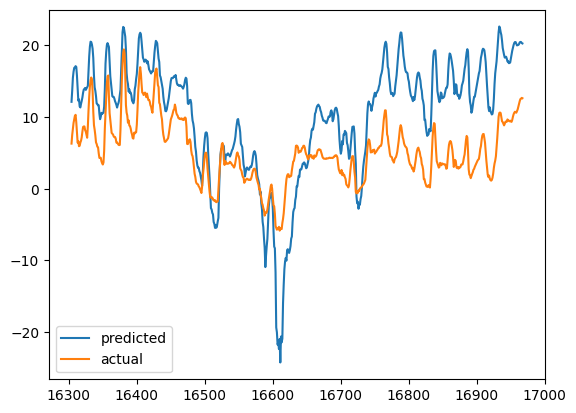

In [62]:
visualisetest(qnn,qxtest,(-1),qpredwin)

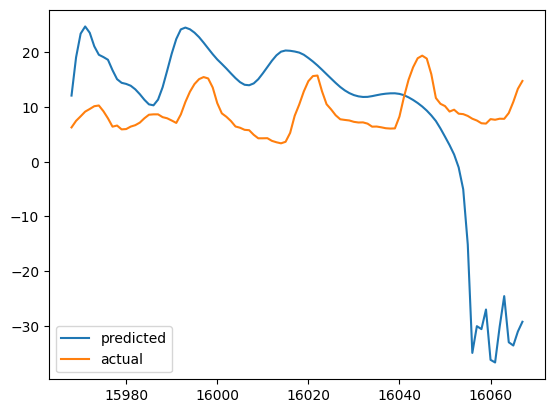

-20.406783413295717

In [63]:
visualsubs(qnn,qxtest,(-1),qpredwin)